In [1]:
# 🧠 U-NET FOR IMAGE DENOISING
# =====================================
# Task: Remove synthetic noise from images using a simple U-Net.
# =====================================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from medmnist import PathMNIST
from medmnist import INFO
from torchmetrics.functional import structural_similarity_index_measure as ssim

# Set reproducibility
torch.manual_seed(42)

# # Prepare noisy MNIST dataset
# class NoisyMNIST(torch.utils.data.Dataset):
#     def __init__(self, train=True):
#         self.data = datasets.MNIST("data", train=train, download=True, transform=transforms.ToTensor())

#     def __getitem__(self, idx):
#         clean_img, _ = self.data[idx]
#         noise = torch.randn_like(clean_img) * 0.5
#         noisy_img = torch.clamp(clean_img + noise, 0., 1.)
#         return noisy_img, clean_img

#     def __len__(self):
#         return len(self.data)
    
# class NoisyCIFAR10(torch.utils.data.Dataset):
#     def __init__(self, train=True, noise_std=0.2):
#         self.data = datasets.CIFAR10("data", train=train, download=True,
#                                      transform=transforms.ToTensor())
#         self.noise_std = noise_std

#     def __getitem__(self, idx):
#         clean_img, _ = self.data[idx]
#         noise = torch.randn_like(clean_img) * self.noise_std
#         noisy_img = torch.clamp(clean_img + noise, 0., 1.)
#         return noisy_img, clean_img

#     def __len__(self):
#         return len(self.data)

class CustomPathMNIST(torch.utils.data.Dataset):
    def __init__(self, split='train', mask_ratio=0.5, noise_std=0.2):
        info = INFO['pathmnist']
        self.data = PathMNIST(root='data', split=split, download=True, transform=transforms.ToTensor())
        self.mask_ratio = mask_ratio  # percent of pixels to zero out
        self.noise_std = noise_std    # standard deviation of noise

    def __getitem__(self, idx):
        clean_img, _ = self.data[idx]  # shape [3, 28, 28]

        # Add noise to the image
        noise = torch.randn_like(clean_img) * self.noise_std
        noisy_img = torch.clamp(clean_img + noise, 0., 1.)

        # Generate binary mask with 1s for pixels to keep
        mask = (torch.rand(1, *clean_img.shape[1:]) > self.mask_ratio)
        undersampled_noisy_img = noisy_img * mask  # zero out random pixels

        return undersampled_noisy_img, clean_img  # (input, target)
    
    def __len__(self):
        return len(self.data)

train_data = CustomPathMNIST(split='train', mask_ratio=0.8, noise_std=0.03)
subset_indices = torch.randperm(len(train_data)) # [:50000]
train_loader = DataLoader(
    Subset(train_data, subset_indices),
    batch_size=64,
    shuffle=True,
)
test_loader = DataLoader(
    CustomPathMNIST(split='test', mask_ratio=0.8, noise_std=0.03),
    batch_size=64,
)

In [2]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def CBR(in_ch, out_ch):  # Conv → BatchNorm → ReLU
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        # Encoder
        self.enc1 = nn.Sequential(CBR(3, 64), CBR(64, 64))
        self.enc2 = nn.Sequential(CBR(64, 128), CBR(128, 128))
        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(CBR(128, 256), CBR(256, 256))

        # Decoder
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(CBR(256, 128), CBR(128, 128))

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(CBR(128, 64), CBR(64, 64))

        self.final = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)  # [B, 32, 28, 28]
        e2 = self.enc2(self.pool(e1))  # [B, 64, 14, 14]

        b = self.bottleneck(self.pool(e2))  # [B, 128, 7, 7]

        d1 = self.up1(b)  # [B, 64, 14, 14]
        d1 = self.dec1(torch.cat([d1, e2], dim=1))  # skip connection

        d2 = self.up2(d1)  # [B, 32, 28, 28]
        d2 = self.dec2(torch.cat([d2, e1], dim=1))

        return torch.sigmoid(self.final(d2))  # Keep in [0, 1]

In [3]:
def combined_loss(pred, target, alpha=0.8):
    """
    alpha: weight on SSIM (set closer to 1 for more perceptual sharpness)
    """
    ssim_val = ssim(pred, target, data_range=1.0)
    mse_val = nn.functional.mse_loss(pred, target)
    return alpha * (1 - ssim_val) + (1 - alpha) * mse_val

  0%|          | 0/1407 [00:00<?, ?it/s]/opt/anaconda3/envs/numpy/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(
100%|██████████| 1407/1407 [19:19<00:00,  1.21it/s]


Epoch 1, Loss: 0.2903


100%|██████████| 1407/1407 [19:51<00:00,  1.18it/s]


Epoch 2, Loss: 0.2702


100%|██████████| 1407/1407 [24:36<00:00,  1.05s/it]


Epoch 3, Loss: 0.2662


100%|██████████| 1407/1407 [28:23<00:00,  1.21s/it]


Epoch 4, Loss: 0.2638


100%|██████████| 1407/1407 [25:54<00:00,  1.11s/it]


Epoch 5, Loss: 0.2623


100%|██████████| 1407/1407 [26:15<00:00,  1.12s/it]


Epoch 6, Loss: 0.2611


100%|██████████| 1407/1407 [20:05<00:00,  1.17it/s]


Epoch 7, Loss: 0.2604


100%|██████████| 1407/1407 [19:57<00:00,  1.18it/s]


Epoch 8, Loss: 0.2595


100%|██████████| 1407/1407 [20:00<00:00,  1.17it/s]


Epoch 9, Loss: 0.2590


100%|██████████| 1407/1407 [19:48<00:00,  1.18it/s]


Epoch 10, Loss: 0.2586


100%|██████████| 1407/1407 [19:42<00:00,  1.19it/s]


Epoch 11, Loss: 0.2578


100%|██████████| 1407/1407 [19:56<00:00,  1.18it/s]


Epoch 12, Loss: 0.2578


100%|██████████| 1407/1407 [19:43<00:00,  1.19it/s]


Epoch 13, Loss: 0.2571


100%|██████████| 1407/1407 [19:43<00:00,  1.19it/s]


Epoch 14, Loss: 0.2569


100%|██████████| 1407/1407 [19:45<00:00,  1.19it/s]


Epoch 15, Loss: 0.2568


100%|██████████| 1407/1407 [19:40<00:00,  1.19it/s]


Epoch 16, Loss: 0.2564


100%|██████████| 1407/1407 [19:42<00:00,  1.19it/s]


Epoch 17, Loss: 0.2563


100%|██████████| 1407/1407 [19:43<00:00,  1.19it/s]


Epoch 18, Loss: 0.2562


100%|██████████| 1407/1407 [19:51<00:00,  1.18it/s]


Epoch 19, Loss: 0.2558


100%|██████████| 1407/1407 [19:41<00:00,  1.19it/s]


Epoch 20, Loss: 0.2557


100%|██████████| 1407/1407 [19:42<00:00,  1.19it/s]


Epoch 21, Loss: 0.2554


100%|██████████| 1407/1407 [19:33<00:00,  1.20it/s]


Epoch 22, Loss: 0.2553


100%|██████████| 1407/1407 [19:31<00:00,  1.20it/s]


Epoch 23, Loss: 0.2552


100%|██████████| 1407/1407 [19:30<00:00,  1.20it/s]


Epoch 24, Loss: 0.2550


100%|██████████| 1407/1407 [19:25<00:00,  1.21it/s]


Epoch 25, Loss: 0.2549


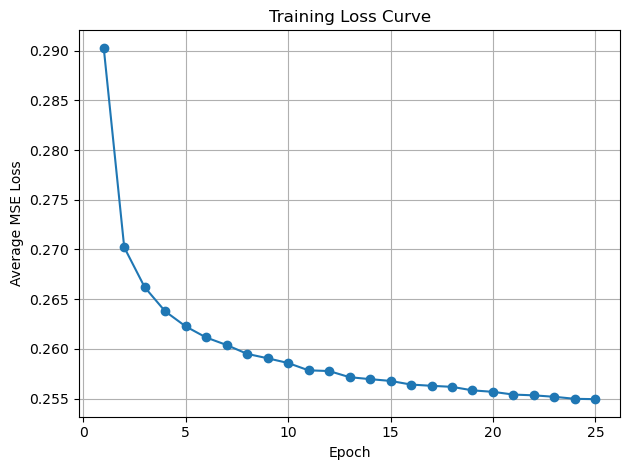

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_history = []

for epoch in range(25):
    model.train()
    total_loss = 0
    for noisy, clean in tqdm(train_loader):
        noisy, clean = noisy.to(device), clean.to(device)
        pred = model(noisy)
        loss = combined_loss(pred, clean)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# 📉 Plot the loss curve
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average MSE Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Save entire model + optimizer state (for resuming training or inference)
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}
if not os.path.exists("unet_checkpoints"):
    os.makedirs("unet_checkpoints")
path = "unet_checkpoints/unet_pathmnist.pth"
torch.save(checkpoint, path)
print("Model saved to ", path)

Model saved to  unet_checkpoints/unet_pathmnist.pth


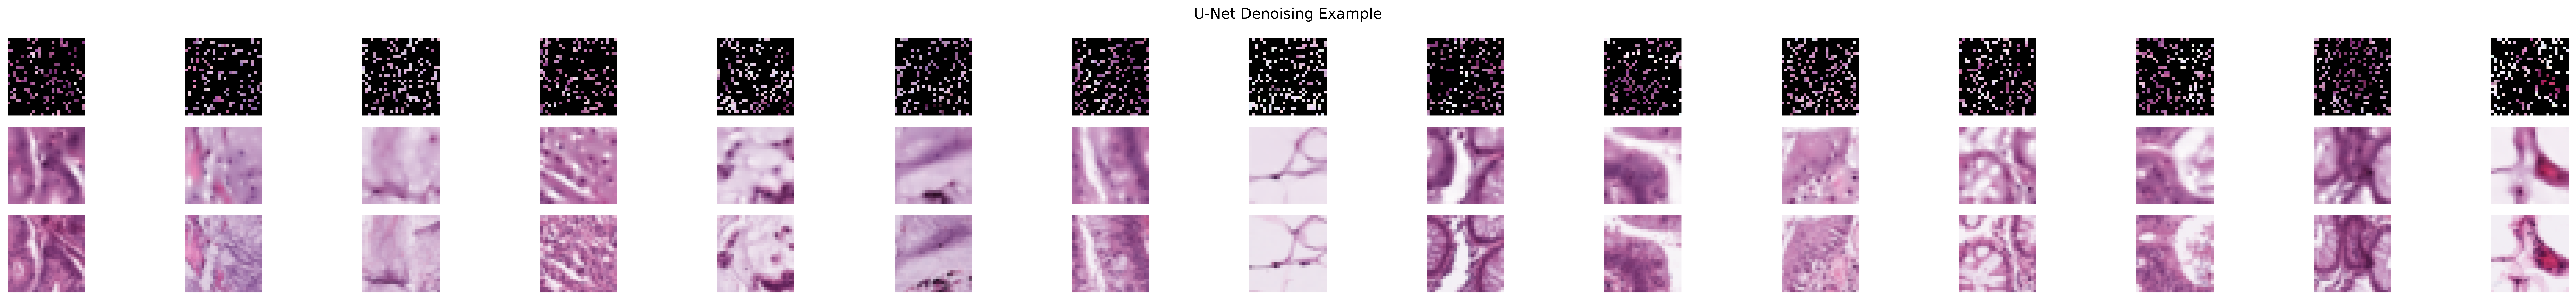

In [6]:
model.eval()
noisy_batch, clean_batch = next(iter(test_loader))
noisy_batch = noisy_batch.to(device)
with torch.no_grad():
    denoised = model(noisy_batch).cpu()

plt.figure(figsize=(36, 4), dpi=600)
for i in range(15):
    for j, img in enumerate([noisy_batch.cpu(), denoised, clean_batch]):
        plt.subplot(3, 15, i + 1 + j * 15)
        plt.imshow(img[i].permute(1, 2, 0))  # show full RGB
        plt.axis("off")
        if i == 0:
            plt.ylabel(["Noisy", "Denoised", "Clean"][j])

plt.suptitle("U-Net Denoising Example", fontsize=14)
plt.tight_layout()
plt.show()